# Rubbish Classifier

This is the first attend to create a rubbish classifier by creating a Deep Learning model using computer vision.

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn 

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data

For our rubbish clasifier we have the following nine label classes:

1. cans (softdrinks, beer, etc..)
2. carton_boxes (Milk boxes, Juice Boxes, etc...)
3. coffee_cups (Takeaway coffe cups)
4. glass_bottles (Beer bottles, wine bottles, spirits bottles, etc...)
5. paper_bags (Shopping paper bags)
6. plastic_bags (shopping plastic bags)
7. plastic_bottles (Milk plastic bottles, water, juices, etc...)
8. takeaway_containers (carboard takeaway conteiners)
9. tissues (tissues, napkins)

Where the ideal is to divide the data into 75% train data and 25% test data.

However, `rubbish_classifier_v0.001` is our first approach, so at the moment we have enough data to train only on the classes **cans, carton_boxes, coffee_cups** and **glass_bottles**

In [2]:
import requests
import zipfile
import os
from pathlib import Path

# Setup a path to a data folder
data_path = Path("data/")
images_path = data_path / "images_dataset"

# If the data folder doesn't exist, download it and prepare it.
if images_path.is_dir():
    print(f"'{images_path}' directory already exists, skipping directory creation...")
else:
    print(f"'{images_path}' does not exist, creating directory...")
    images_path.mkdir(parents=True, exist_ok=True)

# Download data
try:
    import gdown
except:
    !pip install gdown
    import gdown

url = 'https://drive.google.com/uc?id=1M-jVb1fw5TZrHsBecIE-EYDkcNVqoCSq'
output = str(data_path)+'/images.zip'
gdown.download(url, output, quiet=False)

# Unzip data
with zipfile.ZipFile(data_path / "images.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(data_path)
    
os.remove(str(data_path)+"/images.zip")

'data\images_dataset' does not exist, creating directory...


Downloading...
From: https://drive.google.com/uc?id=1M-jVb1fw5TZrHsBecIE-EYDkcNVqoCSq
To: c:\Users\juanb\Documents\AI\rubbish_classifier\data\images.zip
100%|██████████| 481M/481M [00:25<00:00, 19.1MB/s] 


Unzipping data...


### 1.1 Converting all images to jpg format

`tqdm` source https://github.com/tqdm/tqdm

In [3]:
# Fucntion to convert from any image format to jpg
import os, sys
from pathlib import Path
from PIL import Image

# Install tqdm to show smart progess meter
try:
    from tqdm import tqdm
except:
    !pip install tqdm
    from tqdm import tqdm

def image_convertor(path: str, format: str):
    count=0
    path=Path(path)
    for file in tqdm(path.glob("./*")):
        f, e = os.path.splitext(file)
        renameFile = f + "."+format.lower()
        if e.lower() != "."+format.lower():
            old_file=file
            count+=1
            try:
                with Image.open(file) as img:
                    img.save(renameFile)
            except OSError:
                print("cannot convert", file)
            os.remove(old_file)
    print(f"{count} images converted to '{format}' in '{path}'")

In [4]:
# cans class convertion
image_convertor(path="data/dataset/cans/",
                format="jpg")
# carton_boxes class convertion
image_convertor(path="data/dataset/carton_boxes/",
                format="jpg")
# coffee_cups class convertion
image_convertor(path="data/dataset/coffee_cups/",
                format="jpg")
# glass_bottles class convertion
image_convertor(path="data/dataset/glass_bottles/",
                format="jpg")

112it [00:00, 55494.63it/s]


0 images converted to 'jpg' in 'data\dataset\cans'


89it [00:07, 11.81it/s]


66 images converted to 'jpg' in 'data\dataset\carton_boxes'


169it [00:14, 11.95it/s]


125 images converted to 'jpg' in 'data\dataset\coffee_cups'


121it [00:04, 25.33it/s]

42 images converted to 'jpg' in 'data\dataset\glass_bottles'


### 1.2 Split data into train and test dataset by using `split-folders`

Source https://github.com/jfilter/split-folders

In [5]:
# get split-folders ready to use
import shutil

try:
    import splitfolders
except:
    !pip install split-folders[full]
    import splitfolders

# Define input and output folders
input_folder = "data/dataset/"
output_folder = str(images_path)

splitfolders.fixed(input_folder, output= output_folder,
                   seed=42, fixed=(0, 30), move=True)

shutil.rmtree("data/dataset")
shutil.rmtree("data\images_dataset/val")

Copying files: 491 files [00:00, 1111.91 files/s]


## 2. Data preparation

### 2.1 Look inside de dataset

In [6]:
import os
def inside_dir(path: Path):
    """Check what is inside a directory"""
    for dir_path, dir_names, file_names in os.walk(path):
        print(f"There are {len(dir_names)} directories and {len(file_names)} images in '{dir_path}")

In [7]:
inside_dir(images_path)

There are 2 directories and 0 images in 'data\images_dataset
There are 4 directories and 0 images in 'data\images_dataset\test
There are 0 directories and 30 images in 'data\images_dataset\test\cans
There are 0 directories and 30 images in 'data\images_dataset\test\carton_boxes
There are 0 directories and 30 images in 'data\images_dataset\test\coffee_cups
There are 0 directories and 30 images in 'data\images_dataset\test\glass_bottles
There are 4 directories and 0 images in 'data\images_dataset\train
There are 0 directories and 82 images in 'data\images_dataset\train\cans
There are 0 directories and 59 images in 'data\images_dataset\train\carton_boxes
There are 0 directories and 139 images in 'data\images_dataset\train\coffee_cups
There are 0 directories and 91 images in 'data\images_dataset\train\glass_bottles


### 2.2 Setup train and test directory path

In [8]:
train_dir = images_path / "train"
test_dir = images_path / "test"

train_dir, test_dir

(WindowsPath('data/images_dataset/train'),
 WindowsPath('data/images_dataset/test'))

### 2.3 Visualize a random image from the database

Steps and instructions:

1. Get all image paths.
2. Choose a random image path by Python's `random.choice()`.
3. Get image class by `pathlib.Path.parent.stem`.
4. Open image with Python's `PIL`.
5. Show image and its metadata.

Image at: data\images_dataset\test\coffee_cups\IMG_0267.jpg
Image class: coffee_cups
Image height: 2048
Image width: 1536


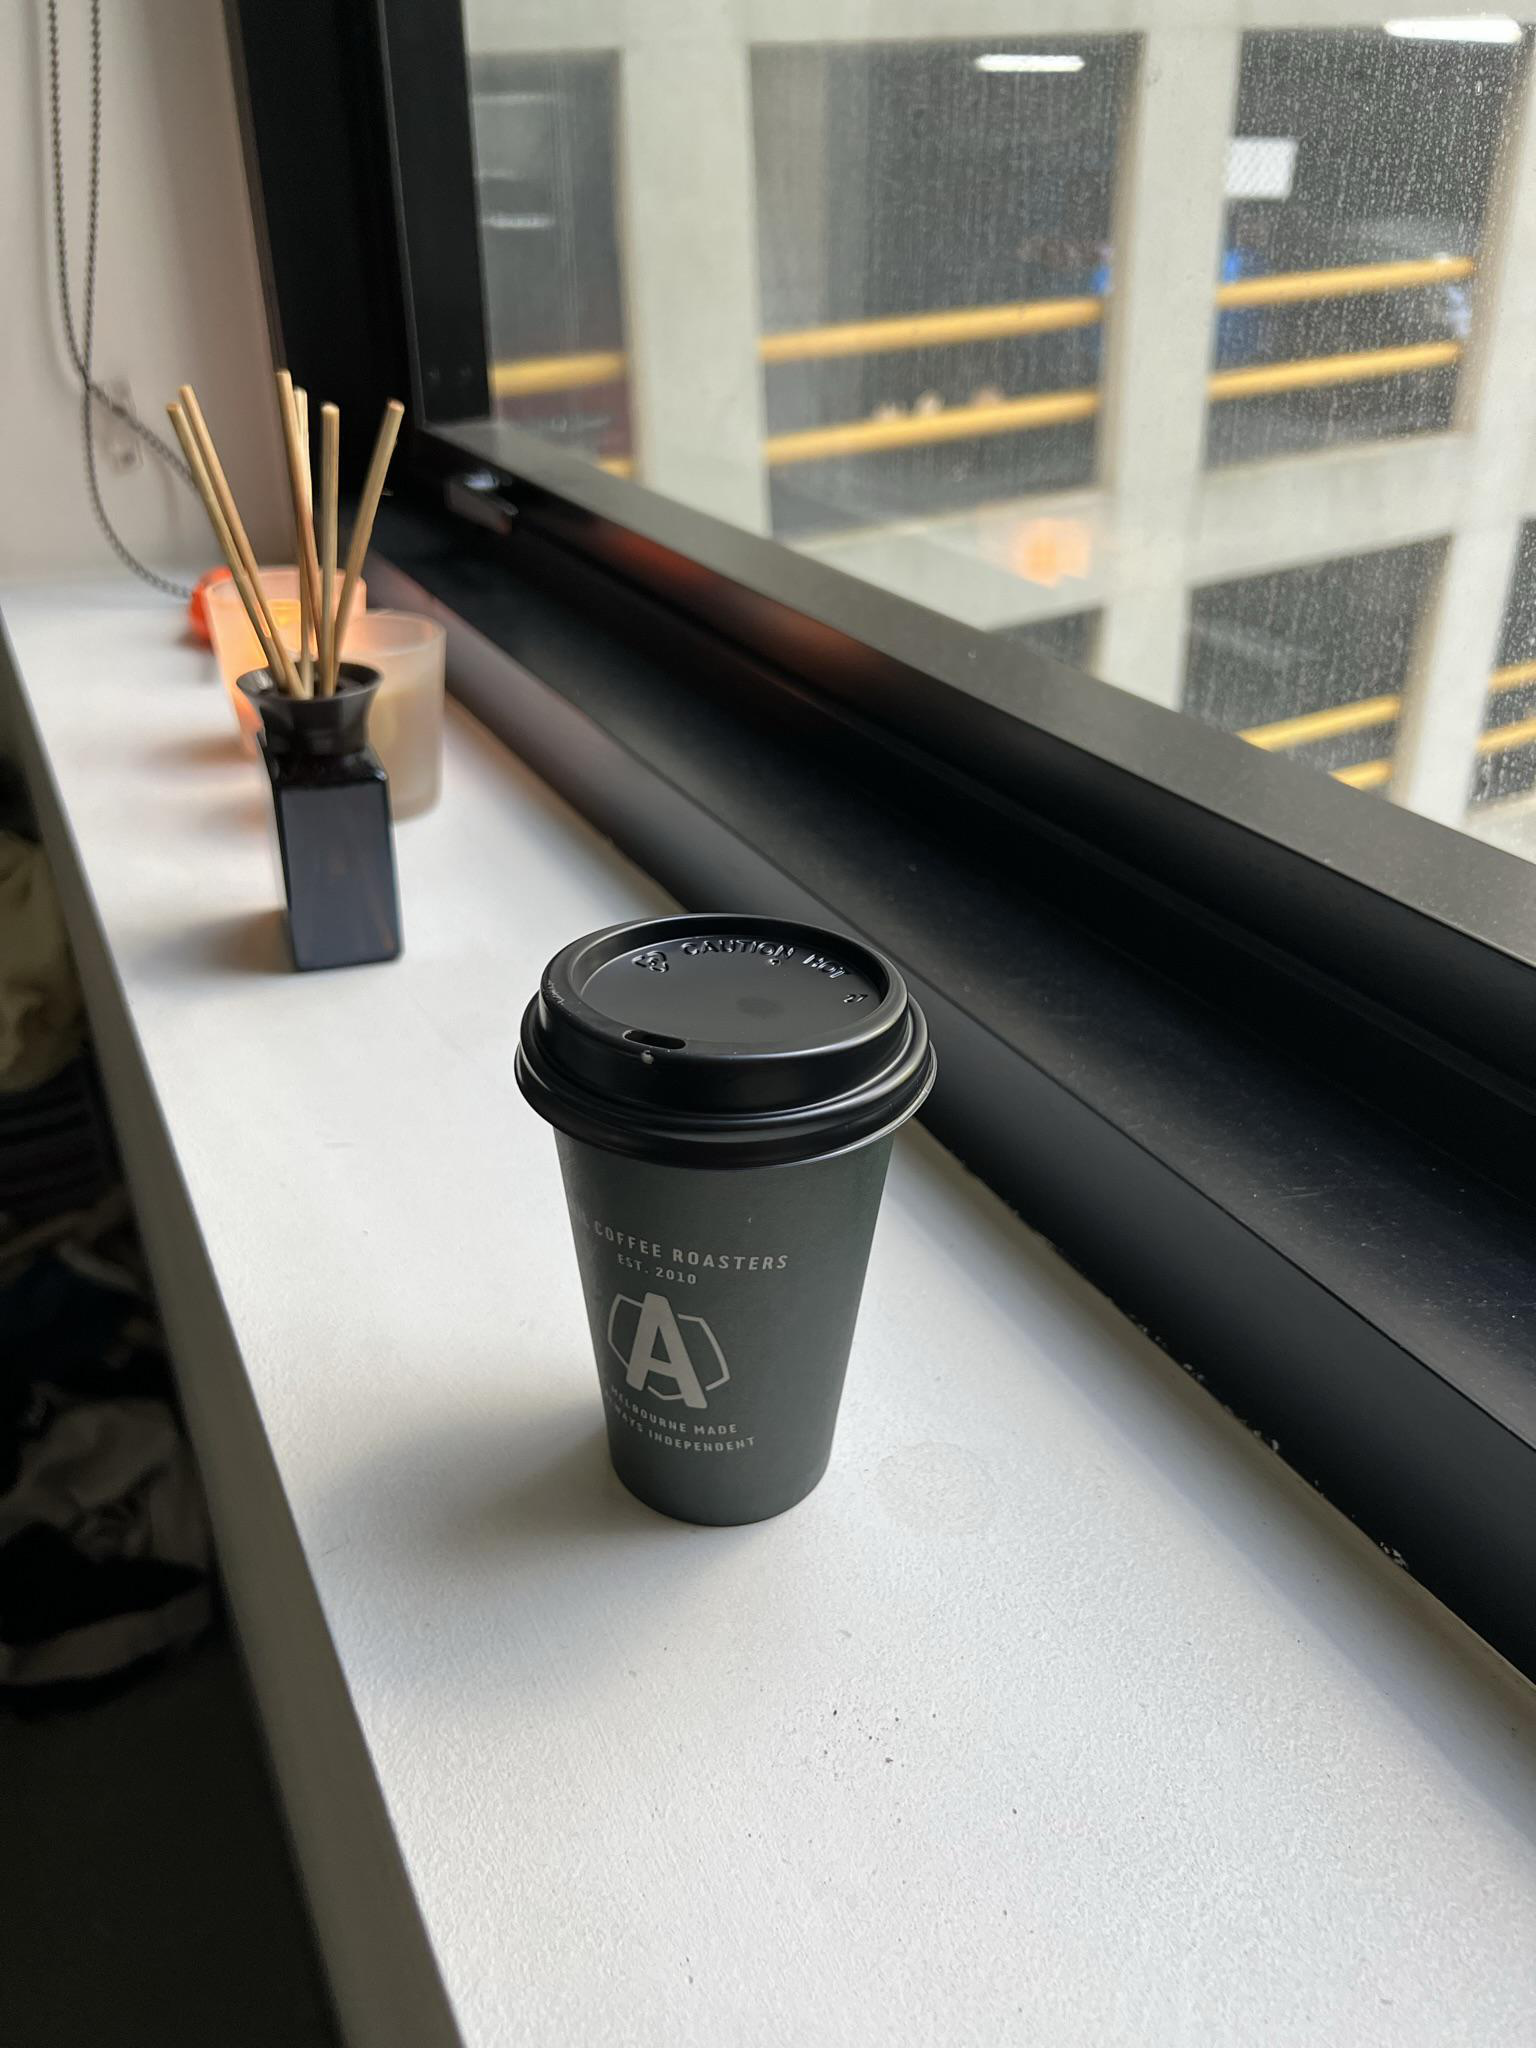

In [9]:
import random
from PIL import Image

# 1. All image paths
images_path_list = list(images_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(images_path_list)

# 3. Get image class from path name (corresponds to the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Show and print metadata
print(f"Image at: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## 3. Data transformation

Steps:

1. Turn data into tensors (numerical representation of the images.
2. Turn data into a `torch.utils.data.Dataset` and subsequently into a `torch.utils.data.DataLoader`.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transform data with `torchvision.transforms`

Get data ready to be used with a model/perform data uagmentation

In [11]:
# Transform
train_transform = transforms.Compose([
    # Resize images
    transforms.Resize(size=255, max_size=256),
    transforms.CenterCrop(size=256),
    # turn the image into a torch.Tensor
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    # Resize images
    transforms.Resize(size=255, max_size=256),
    transforms.CenterCrop(size=256),
    # turn the image into a torch.Tensor
    transforms.ToTensor()
])

### 3.2 Visualize transformation

In [12]:
import matplotlib.pyplot as plt

def plot_tranformed_img(images_path: list, 
                        transform, 
                        n=3, #Num of images
                        seed=None):
    """
    Sellects random images from a directory path and loads/transforms
    them, then plots original againts transformed
    """
    if seed:
        random.seed(seed)
    image_paths = random.sample(images_path, k=n)
    for image_path in image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

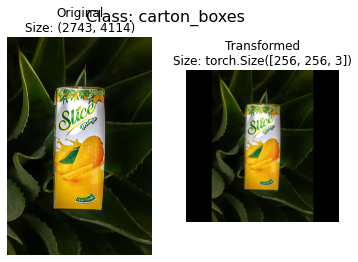

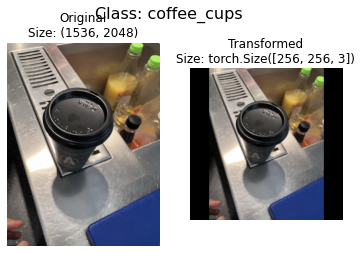

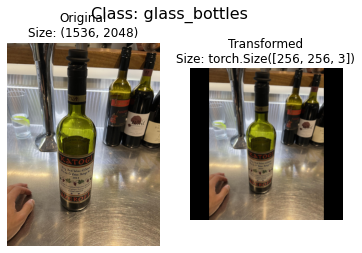

In [22]:
plot_tranformed_img(images_path=images_path_list,
                    transform=train_transform,
                    n=3)

## 4. Load image data using `ImageFolder`

In [23]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 371
     Root location: data\images_dataset\train
     StandardTransform
 Transform: Compose(
                Resize(size=255, interpolation=bilinear, max_size=256, antialias=None)
                CenterCrop(size=(256, 256))
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 120
     Root location: data\images_dataset\test
     StandardTransform
 Transform: Compose(
                Resize(size=255, interpolation=bilinear, max_size=256, antialias=None)
                CenterCrop(size=(256, 256))
                ToTensor()
            ))

In [24]:
# Get class names
class_names = train_data.classes
class_names

['cans', 'carton_boxes', 'coffee_cups', 'glass_bottles']

In [25]:
# Get class names as dictionary
class_dict = train_data.class_to_idx
class_dict

{'cans': 0, 'carton_boxes': 1, 'coffee_cups': 2, 'glass_bottles': 3}

In [26]:
# Check lengths of datasets
len(train_data), len(test_data)

(371, 120)

### 4.1 Display random images from one of the datasets

In [27]:
import matplotlib.pyplot as plt

# Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: list[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")
    
    # Set seed
    if seed:
        random.seed(seed)
    
    # Get random sample indexes
    samples_idx = random.sample(range(len(dataset)), k=n)

    # Setup plot
    plt.figure(figsize=(16,8))

    # Loop through random indexes
    for i, targ_sample in enumerate(samples_idx):
        targ_img, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust tensor dimension to be able to plot
        targ_img = targ_img.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

        # Plot
        plt.subplot(1, n, i+1)
        plt.imshow(targ_img)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {targ_img.shape}"
        plt.title(title)

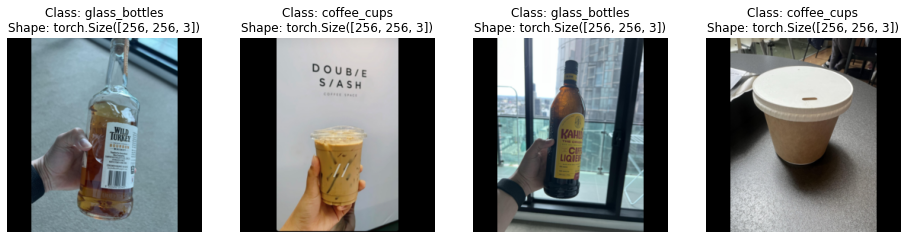

In [30]:
# Display random images from datasets
display_random_images(dataset=train_data,
                      n=4,
                      classes=class_names)

### 4.2 Turn datasets into `DataLoader`

`DataLoader` turns a `Dataset` into iterables with the option of change the `batch_size`.

In [31]:
import os
from torch.utils.data import DataLoader

# Turn train and set datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x11e5eb1a5b0>,
 <torch.utils.data.dataloader.DataLoader at 0x11e5eb1a2e0>)

In [32]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 256, 256]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 5. Model 0: TinyVGG

TinyVGG from the CNN Explainer but changing input shape from **64 x 64** to **256 x 256**

Source: https://poloclub.github.io/cnn-explainer/

### 5.1 TinyVGG model class

In [33]:
class TinyVGG(nn.Module):
    """
    Model architecture of TinyVGG from CNN Explainer
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride values are same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride values are same as kernel_size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*3721,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [34]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=37210, out_features=4, bias=True)
  )
)

### 5.2 `torchinfo` to get an idea of the shapes through the model

In [35]:
# Install torchinfo
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[32, 3, 256, 256])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 4]                   --
├─Sequential: 1-1                        [32, 10, 126, 126]        --
│    └─Conv2d: 2-1                       [32, 10, 254, 254]        280
│    └─ReLU: 2-2                         [32, 10, 254, 254]        --
│    └─Conv2d: 2-3                       [32, 10, 252, 252]        910
│    └─ReLU: 2-4                         [32, 10, 252, 252]        --
│    └─MaxPool2d: 2-5                    [32, 10, 126, 126]        --
├─Sequential: 1-2                        [32, 10, 61, 61]          --
│    └─Conv2d: 2-6                       [32, 10, 124, 124]        910
│    └─ReLU: 2-7                         [32, 10, 124, 124]        --
│    └─Conv2d: 2-8                       [32, 10, 122, 122]        910
│    └─ReLU: 2-9                         [32, 10, 122, 122]        --
│    └─MaxPool2d: 2-10                   [32, 10, 61, 61]          --
├─Sequentia

### 5.3 train and test loops functions

* `train_step()` - takes in a model and dataloader to train the model on the dataloader
* `test_step()` - takes in a model and dataloader to evaluate the model on the dataloder

In [36]:
# train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through dataloader data batches
    for batch, (X,y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X) # Output model logits

        # Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimize zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # caulculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get the average loss and accuracy per batch
    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc

In [37]:
# test_step()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model to eval mode
    model.eval()

    # Setup test_loss and test_acc values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through dataloader data batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy metric
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels==y).sum().item()/len(test_pred_logits)

    # Adjust metrics to get the average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    return test_loss, test_acc

### 5.4 `train()` function to combine `train_step()` and `test_step()`

In [38]:
from tqdm.auto import tqdm

# Train function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          device=device):
    
    # Empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # Loop through train and test steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # Print out
        print(f"Epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results


### 5.5 Train and evaluate `model_0`

In [39]:
# Set number of epochs
NUM_EPOCHS = 20

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End timer and print total time
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.3578 | train_acc: 0.3380 | test_loss: 1.4371 | test_acc: 0.2344
Epoch: 1 | train_loss: 1.3505 | train_acc: 0.3745 | test_loss: 1.4166 | test_acc: 0.2344
Epoch: 2 | train_loss: 1.3462 | train_acc: 0.3745 | test_loss: 1.4127 | test_acc: 0.2344
Epoch: 3 | train_loss: 1.3365 | train_acc: 0.3823 | test_loss: 1.4370 | test_acc: 0.2344
Epoch: 4 | train_loss: 1.3153 | train_acc: 0.4101 | test_loss: 1.4134 | test_acc: 0.3203
Epoch: 5 | train_loss: 1.2436 | train_acc: 0.4605 | test_loss: 1.3471 | test_acc: 0.4089
Epoch: 6 | train_loss: 1.1433 | train_acc: 0.5326 | test_loss: 1.2943 | test_acc: 0.4583
Epoch: 7 | train_loss: 1.0717 | train_acc: 0.5595 | test_loss: 1.3672 | test_acc: 0.4167
Epoch: 8 | train_loss: 0.9518 | train_acc: 0.6047 | test_loss: 1.2811 | test_acc: 0.4792
Epoch: 9 | train_loss: 0.8666 | train_acc: 0.6456 | test_loss: 1.2530 | test_acc: 0.4375
Epoch: 10 | train_loss: 0.7554 | train_acc: 0.6968 | test_loss: 1.4066 | test_acc: 0.4922
Epoch: 11 | train_lo

### 5.6 Plot the loss curves of `Model_0`

In [40]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots loss curves"""
    # Get the loss values of the results dictionary(training and testing)
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary(training and testing)
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]

    # Number of epochs
    epochs = range(len(results["train_loss"]))

    # Setup plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend();

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="train_accuracy")
    plt.plot(epochs, test_acc, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

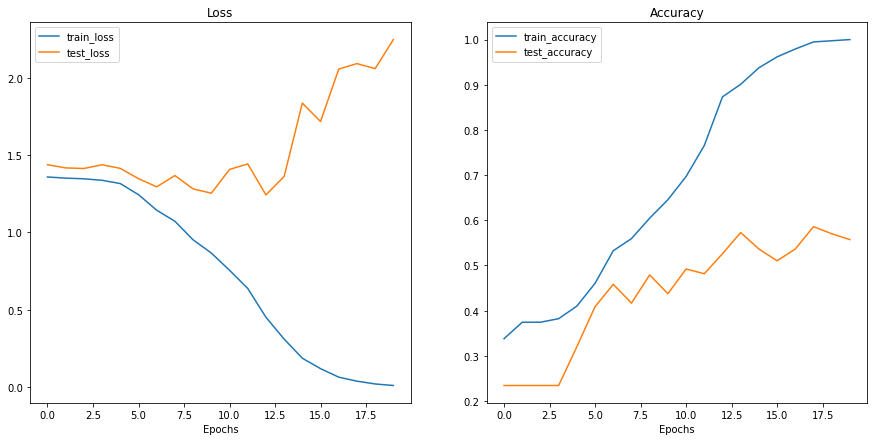

In [41]:
plot_loss_curves(model_0_results)

## 6. Making a prediction

Make a prediction with a smaple/image that is not in either training or testing dataset.

In [45]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "random_sample.jpg"

# Download image if it does not exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://img.freepik.com/free-photo/front-view-red-wine-bottle-red-wine-along-with-black-grapes-green-leaves-isolated-grey-desk-alcohol-winery-drink_140725-16095.jpg?w=2000")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exist.")

In [46]:
custom_image_path = data_path / "random_sample.jpg"

### 6.1 Load sample with PyTorch

Original shape: torch.Size([3, 3000, 2000])
Transformed shape: torch.Size([3, 256, 256])


(-0.5, 255.5, 255.5, -0.5)

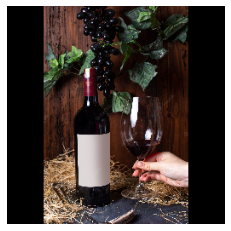

In [47]:
import torchvision
from torchvision import transforms

# Load sample
sample_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255.

# Transform for the sample
sample_transform = transforms.Compose([
    # Resize images
    transforms.Resize(size=255, max_size=256),
    transforms.CenterCrop(size=256),
])

sample_image_transformed = sample_transform(sample_image)

# Print out shapes and image
print(f"Original shape: {sample_image.shape}")
print(f"Transformed shape: {sample_image_transformed.shape}")

plt.imshow(sample_image_transformed.permute(1, 2, 0));
plt.axis(False)


### 6.2 Make prediction

In [48]:
model_0.eval()
with torch.inference_mode():
    sample_image_pred = model_0(sample_image_transformed.unsqueeze(0).to(device))

sample_image_label = torch.argmax(torch.softmax(sample_image_pred, dim=1), dim=1).cpu()
print(class_names[sample_image_label])

coffee_cups
